In [1]:
import lbg_forecast.priors_gp_massfunc as gpmf
import numpy as np
import matplotlib.pyplot as plt


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/gpytorch/likelihoods/noise_models.py:150: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 1e-06.
  warnings.warn(


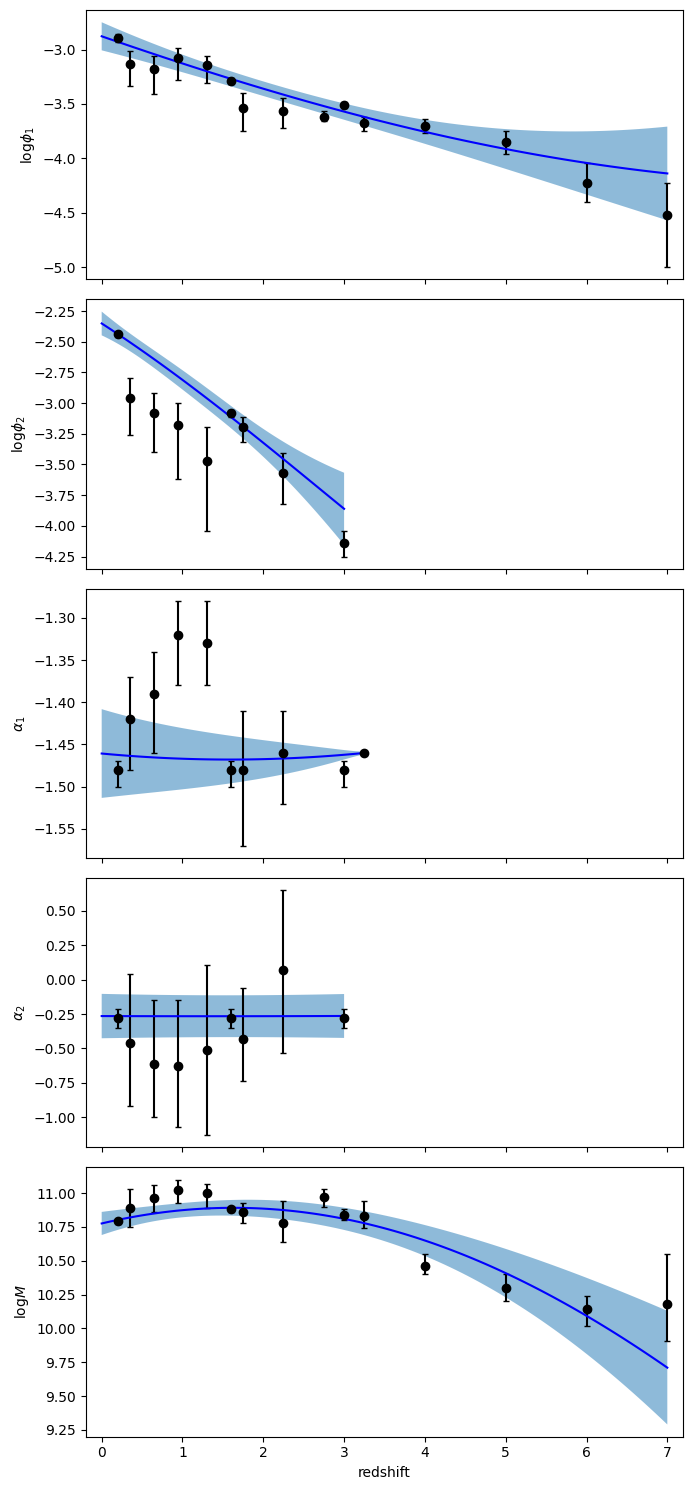

In [2]:
mass_function_prior = gpmf.MassFunctionPrior()

mass_function_prior.plot_confidence()

z_grid = np.linspace(0.0, 7.0, 50)
nsamples=10000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
selected_curves = pr.select_allowed_parameter_curves(z_grid, curves)
pr.plot_mass_function_parameter_curves(z_grid, selected_curves, log_phi_plot=False, alpha=0.1)


z_grid = np.linspace(0.0, 7.0, 50)
nsamples=1000000
curves = pr.mass_function_parameter_curves(z_grid, nsamples, truth=False)
allowed_curves = pr.select_allowed_parameter_curves(z_grid, curves)

sampled_curves = pr.sample_allowed_parameter_curves(z_grid, 1000, allowed_curves)
print(sampled_curves[0].shape, sampled_curves[1].shape, sampled_curves[2].shape, sampled_curves[3].shape, sampled_curves[4].shape)
pr.plot_mass_function_parameter_curves(z_grid, sampled_curves, log_phi_plot=False, alpha=0.1)

prior_data = pr.preload_prior_data(zmax=7.0)

zsamples, logmsamples = pr.sample_redshift_mass_prior(100000, prior_data, prior_bounds=[0.0,7.0,7,13], plotting=True)